The aim of this notebook is to test `BayesPy` potential on modelling Gaussian mixtures. Two attepts are done, the first on the proper `Breast Cancer Wisconsin` dataset, and the second on a two-dimensional reduction using a variational auto-encoder.

The mixture is componed by the same number of components as classes has the dataset. An optimal outcome would be that each class is modeled by one component. In order to test this, we are using each datapoint posterior probability of belonging to each component to compute a density function over each class and component. 

# Imports and dataset

In [1]:
# Imports
from functions import *
from models import *
from bayespy import nodes
from bayespy.inference import VB
# seed
set_seed(2020)

Using TensorFlow backend.


Load and prepare Breast Cancer database

In [2]:
# Column names
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]
# Reading dataset
dataset = pd.read_csv('../dataset/wdbc.data', header=None, names= col_names)
X = dataset.drop(['id','diagnosis'], axis=1)
y = dataset['diagnosis']

# Constants

In [3]:
# Ammount of samples
n_samples = X.shape[0]
# Observed space dimensionality
dim = X.shape[1]
# Ammount of classes
n_classes = len(y.unique())

# BayesPy

## Model definition

Mean and precision distribucion defined as
$$
\mu \sim \mathcal{N}_{dim}(0,I) \quad \text{and} \quad \Lambda \sim \mathcal{W}(dim,I_{dim}).
$$

Mixture weights follow a Dirichlet distribution
$$
    \pi \sim \text{Symmetric-Dirichlet}\Big(\frac{1}{n\_components}\Big).
$$

The variable modeling the component assignation follows a categorical distribution as
$$
    Z_n \sim \text{Categorical}(\pi).
$$

In [4]:
# Define a function that returns all the variables of the model.
def GaussianMixture(dim, n_components, n_samples):
    Lambda = nodes.Wishart(dim, np.identity(dim), plates=(n_components,))
    mu = nodes.Gaussian(np.zeros(dim), np.identity(dim), plates=(n_components,))
    pi = nodes.Dirichlet(np.ones(n_components)/n_components)
    z = nodes.Categorical(pi, plates=(n_samples,))
    x = nodes.Mixture(z, nodes.Gaussian, mu, Lambda)

    return x, z, pi, mu, Lambda

## Breast Cancer Diagnosys

We define the model using the dataset dimensions.

In [5]:
x, z, pi, mu, Lambda = GaussianMixture(dim = X.shape[1], 
                                       n_components = len(y.unique()), 
                                       n_samples = X.shape[0])

`Pandas' dataframes` can't be used. to observe the data as they raise a dimensionality error. We may transform it to a `Numpy` array.

In [6]:
x.observe(X.to_numpy())

Create the inference object.

In [7]:
Q = VB(x, mu, z, Lambda, pi)

Initialize `z` using random values as letting the default initialization (prior) leads to the same 2 distributions.

In [8]:
z.initialize_from_random()

Start learning.

In [9]:
Q.update(repeat=1000)

Iteration 1: loglike=-1.229165e+06 (0.057 seconds)
Iteration 2: loglike=-6.573372e+03 (0.081 seconds)
Iteration 3: loglike=-4.811194e+03 (0.086 seconds)
Iteration 4: loglike=-4.195404e+03 (0.077 seconds)
Iteration 5: loglike=-3.934526e+03 (0.071 seconds)
Iteration 6: loglike=-3.685506e+03 (0.057 seconds)
Iteration 7: loglike=-3.414732e+03 (0.058 seconds)
Iteration 8: loglike=-3.123762e+03 (0.063 seconds)
Iteration 9: loglike=-2.913217e+03 (0.061 seconds)
Iteration 10: loglike=-2.764515e+03 (0.054 seconds)
Iteration 11: loglike=-2.630799e+03 (0.050 seconds)
Iteration 12: loglike=-2.523561e+03 (0.058 seconds)
Iteration 13: loglike=-2.456218e+03 (0.059 seconds)
Iteration 14: loglike=-2.414676e+03 (0.051 seconds)
Iteration 15: loglike=-2.393060e+03 (0.053 seconds)
Iteration 16: loglike=-2.365463e+03 (0.052 seconds)
Iteration 17: loglike=-2.321662e+03 (0.054 seconds)
Iteration 18: loglike=-2.309745e+03 (0.051 seconds)
Iteration 19: loglike=-2.284863e+03 (0.048 seconds)
Iteration 20: loglike

Iteration 158: loglike=-2.005769e+03 (0.055 seconds)
Iteration 159: loglike=-2.005676e+03 (0.048 seconds)
Iteration 160: loglike=-2.005584e+03 (0.049 seconds)
Iteration 161: loglike=-2.005494e+03 (0.050 seconds)
Iteration 162: loglike=-2.005405e+03 (0.049 seconds)
Iteration 163: loglike=-2.005317e+03 (0.062 seconds)
Iteration 164: loglike=-2.005231e+03 (0.062 seconds)
Iteration 165: loglike=-2.005146e+03 (0.057 seconds)
Iteration 166: loglike=-2.005062e+03 (0.052 seconds)
Iteration 167: loglike=-2.004980e+03 (0.051 seconds)
Iteration 168: loglike=-2.004899e+03 (0.053 seconds)
Iteration 169: loglike=-2.004818e+03 (0.049 seconds)
Iteration 170: loglike=-2.004739e+03 (0.050 seconds)
Iteration 171: loglike=-2.004662e+03 (0.054 seconds)
Iteration 172: loglike=-2.004585e+03 (0.050 seconds)
Iteration 173: loglike=-2.004510e+03 (0.051 seconds)
Iteration 174: loglike=-2.004435e+03 (0.049 seconds)
Iteration 175: loglike=-2.004362e+03 (0.051 seconds)
Iteration 176: loglike=-2.004289e+03 (0.049 se

Each component probability may be inspected using `pi`.

In [10]:
print(pi)

 ~ Dirichlet(alpha)
  alpha =
[  6.5 563.5]


`Z` models each datapoint component and its first moment shows the probability of belonging to each component.

In [11]:
print(z.u[0][y == "B"])

[[6.42285340e-323 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [5.68872459e-300 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [6.63946041e-291 1.

Plot each component belonging density.

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


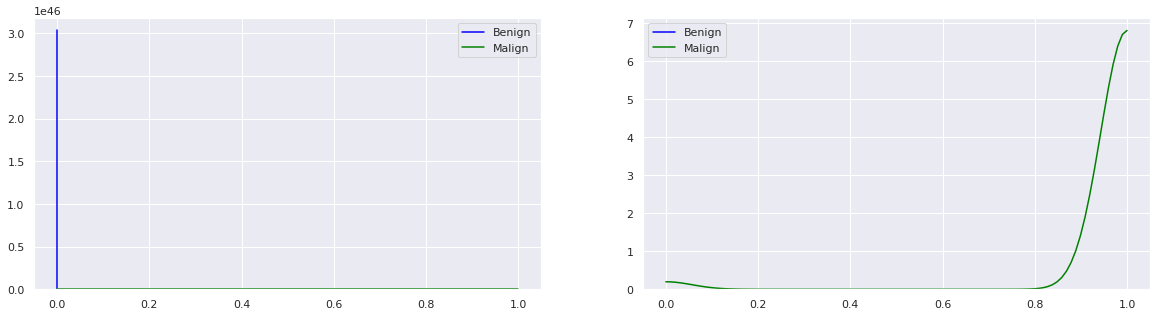

In [12]:
plot_mixture_distplot([z.u[0][y=="B"],z.u[0][y=="M"]], ["Benign", "Malign"], ["blue","green"], 
                      n_components = n_classes)

The model has not correctly learned the data, leading to a model where almost every datapoint belongs to the same component. 

Posterior samples can be generated using `random()`.

In [13]:
print(x.random())

[[ 0.0743429   0.00527335  0.03188536 ...  0.22342627 -0.00308106
   0.25700646]
 [-0.20450711  0.09625717  0.23256486 ... -0.14408407 -0.20263355
  -0.06837617]
 [ 0.2995369  -0.2177071  -0.00289559 ... -0.08487693 -0.00755265
  -0.10025784]
 ...
 [-0.00974389 -0.15705131 -0.01358923 ...  0.05708143  0.20126379
  -0.01745082]
 [-0.3000618  -0.13105361  0.20172223 ... -0.09875572 -0.02680159
  -0.04544714]
 [ 0.22298444  0.16012556  0.03350916 ... -0.01141511 -0.34832426
  -0.09770239]]


## Reduced space

We use a variational auto-encoder to reduce the data to a two-dimensional space.

In [14]:
vae_model = vae(2, 100, dim)
q_vae = Q_vae(2, 100, dim)

optimizer = tf.train.AdamOptimizer(0.01)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=4000)
vae_model.fit({"x": X}, VI_vae)
data = vae_model.posterior("z", data={"x": X}).sample()


 0 epochs	 504412128.0....................
 200 epochs	 6163732.0....................
 400 epochs	 1965005.875....................
 600 epochs	 1292843.875....................
 800 epochs	 911255.0....................
 1000 epochs	 731195.25....................
 1200 epochs	 618658.75....................
 1400 epochs	 551460.0625....................
 1600 epochs	 781488.9375....................
 1800 epochs	 480570.8125....................
 2000 epochs	 410057.6875....................
 2200 epochs	 377567.4375....................
 2400 epochs	 348210.03125....................
 2600 epochs	 329420.78125....................
 2800 epochs	 312858.1875....................
 3000 epochs	 309560.71875....................
 3200 epochs	 297279.78125....................
 3400 epochs	 300119.59375....................
 3600 epochs	 372105.65625....................
 3800 epochs	 260840.1875....................

We define the new mixture model and initialize training.

In [15]:
x, z, pi, mu, Lambda = GaussianMixture(dim = data.shape[1], 
                                       n_components = len(y.unique()), 
                                       n_samples = X.shape[0])
x.observe(data)
Q = VB(x, mu, z, Lambda, pi)
z.initialize_from_random()
Q.update(repeat=1000)

Iteration 1: loglike=-4.193984e+03 (0.008 seconds)
Iteration 2: loglike=-3.848058e+03 (0.006 seconds)
Iteration 3: loglike=-3.788126e+03 (0.006 seconds)
Iteration 4: loglike=-3.766425e+03 (0.006 seconds)
Iteration 5: loglike=-3.753604e+03 (0.006 seconds)
Iteration 6: loglike=-3.746409e+03 (0.006 seconds)
Iteration 7: loglike=-3.742745e+03 (0.008 seconds)
Iteration 8: loglike=-3.740886e+03 (0.007 seconds)
Iteration 9: loglike=-3.739867e+03 (0.006 seconds)
Iteration 10: loglike=-3.739268e+03 (0.006 seconds)
Iteration 11: loglike=-3.738899e+03 (0.006 seconds)
Iteration 12: loglike=-3.738667e+03 (0.006 seconds)
Iteration 13: loglike=-3.738518e+03 (0.011 seconds)
Iteration 14: loglike=-3.738423e+03 (0.008 seconds)
Iteration 15: loglike=-3.738362e+03 (0.009 seconds)
Iteration 16: loglike=-3.738322e+03 (0.011 seconds)
Iteration 17: loglike=-3.738297e+03 (0.010 seconds)
Converged at iteration 17.


In this case, `pi` has correctly learn each component probability.

In [16]:
print(pi)

 ~ Dirichlet(alpha)
  alpha =
[352.82241911 217.17758089]


`BayesPy` has several plotting functions, among them, `gaussian_mixture_2d` should plot all datapoints and Gaussian ellipses. For some reason, it fails to plot both ellipses.

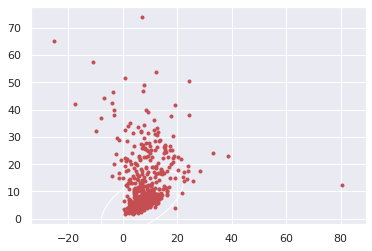

In [17]:
bpplt.gaussian_mixture_2d(x, alpha=pi, scale=5)
bpplt.pyplot.show()

In this case, component belonging densities can be shown. It can be seen that the benign class is strongly modeled by the first component, whereas the malign class is modeled by the second.

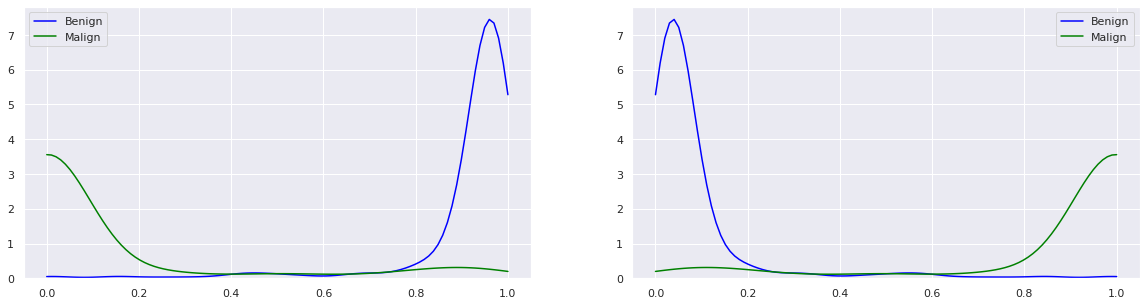

In [18]:
plot_mixture_distplot([z.u[0][y=="B"],z.u[0][y=="M"]], ["Benign", "Malign"], ["blue","green"], 
                      n_components = n_classes)